In [2]:
#pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317161 sha256=0282404f9a4345262f160620293b8b688b66d9a8afcb0e038675eb39fece0f05
  Stored in directory: c:\users\mstanton\appdata\local\pip\cache\wheels\9f\34\a4\159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pyspark
import numpy as np
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import to_date, date_format
from pyspark.sql.functions import col
import configparser

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [3]:
path = config['file_info']['path']

In [4]:
path = config['file_info']['path']
spark = SparkSession.builder.appName('flights').getOrCreate()
files = [path+'\\Combined_Flights_2018.csv',path+'\\Combined_Flights_2019.csv',path+'\\Combined_Flights_2020.csv',path+'\\Combined_Flights_2021.csv',path+'\\Combined_Flights_2022.csv']
df = spark.read.csv(files, header=True)
df.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- DepDelayMinutes: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- ArrDelayMinutes: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT

In [30]:
airline_cancallations_df = df.groupBy('Airline').pivot('Cancelled').agg({"Airline": "count"})
airline_cancallations_df = airline_cancallations_df.withColumn('Total_Flights', col('True') + col('False'))
airline_cancallations_df = airline_cancallations_df.withColumn('Cancellation_Rate', col('True') / col('False'))
airline_cancallations_df = airline_cancallations_df.orderBy(col('Total_Flights').desc())
airline_cancallations_df.show()

+--------------------+-------+------+-------------+--------------------+
|             Airline|  False|  True|Total_Flights|   Cancellation_Rate|
+--------------------+-------+------+-------------+--------------------+
|Southwest Airline...|5302931|171408|      5474339|0.032323256704641264|
|Delta Air Lines Inc.|3248183| 46734|      3294917|0.014387736158954098|
|SkyWest Airlines ...|3087096| 72587|      3159683|0.023513036199716498|
|American Airlines...|3039059| 95058|      3134117| 0.03127876095857303|
|United Air Lines ...|2307477| 47061|      2354538|0.020395002853766258|
|   Republic Airlines|1242774| 40930|      1283704| 0.03293438710497645|
|     JetBlue Airways|1076984| 29095|      1106079|0.027015257422580093|
|           Envoy Air|1036655| 36123|      1072778| 0.03484572977509393|
|   Endeavor Air Inc.| 978031| 20193|       998224|0.020646584821953497|
|         Comair Inc.| 925425| 31795|       957220|0.034357187238295915|
|Alaska Airlines Inc.| 889142| 17117|       906259|

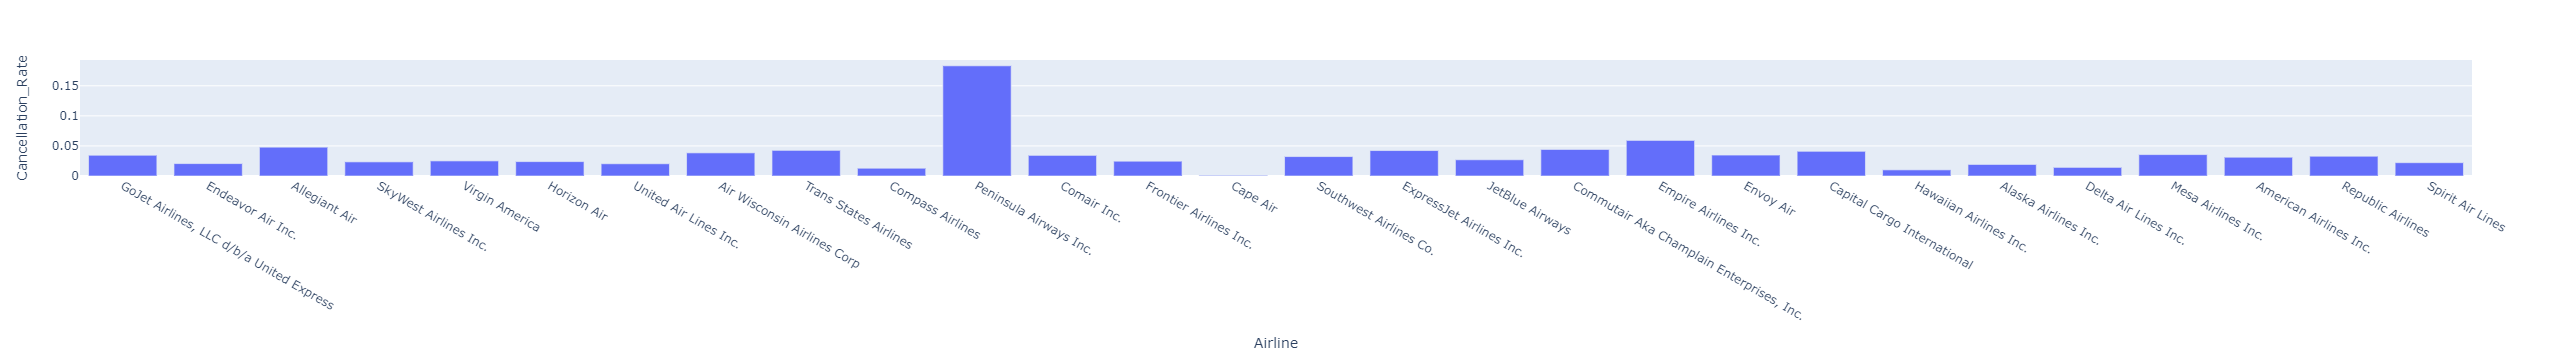

In [18]:
airline_cancallations_pd = airline_cancallations_df.toPandas()
fig = px.bar(airline_cancallations_pd, x='Airline', y='Cancellation_Rate')
fig.show()

In [7]:
df = df.withColumn("date_str", to_date("FlightDate"))
df = df.withColumn("year_month", date_format("date_str", "yyyy-MM"))

In [19]:
monthly_cancellations_df = df.filter(df['Cancelled'] == True).groupBy(['year_month']).agg({"year_month": "count"})

monthly_cancellations_df = monthly_cancellations_df.withColumn("year", date_format("year_month", "yyyy"))
monthly_cancellations_df = monthly_cancellations_df.withColumn("month", date_format("year_month", "MM"))

monthly_cancellations_df = monthly_cancellations_df.orderBy('year','month')

monthly_cancellations_df.show()

+----------+-----------------+----+-----+
|year_month|count(year_month)|year|month|
+----------+-----------------+----+-----+
|   2018-01|            12690|2018|   01|
|   2018-02|             5149|2018|   02|
|   2018-03|             8939|2018|   03|
|   2018-04|             4778|2018|   04|
|   2018-05|             4350|2018|   05|
|   2018-06|             4306|2018|   06|
|   2018-07|             6215|2018|   07|
|   2018-08|            11669|2018|   08|
|   2018-09|             9503|2018|   09|
|   2018-10|             5202|2018|   10|
|   2018-11|             7769|2018|   11|
|   2018-12|             7803|2018|   12|
|   2019-01|            19550|2019|   01|
|   2019-02|            18352|2019|   02|
|   2019-03|            13562|2019|   03|
|   2019-04|            15726|2019|   04|
|   2019-05|            14146|2019|   05|
|   2019-06|            14667|2019|   06|
|   2019-07|            14808|2019|   07|
|   2019-08|            12903|2019|   08|
+----------+-----------------+----

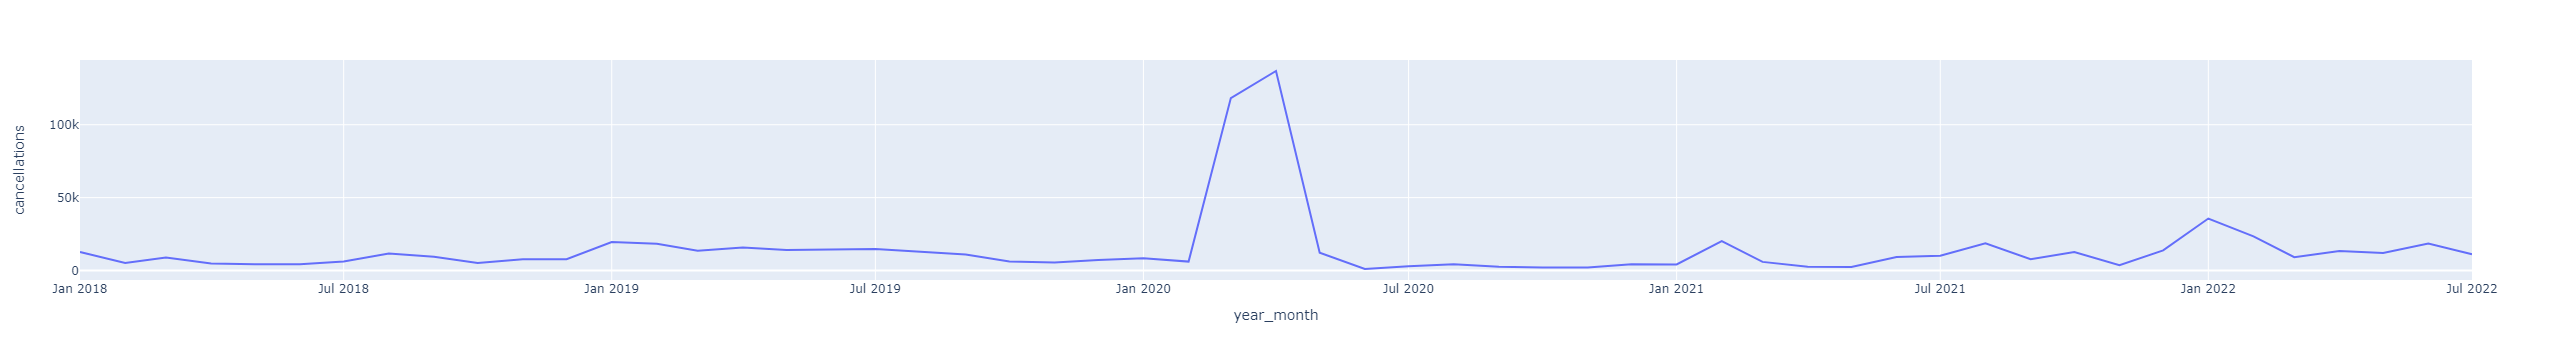

In [21]:
monthly_cancellations_pd = monthly_cancellations_df.toPandas()
fig = px.line(monthly_cancellations_pd, x='year_month', y='count(year_month)')
fig.update_yaxes(title='cancellations')
fig.show()

In [26]:
origin_cancallations_df = df.groupBy('Origin').pivot('Cancelled').agg({"Origin": "count"})
origin_cancallations_df = origin_cancallations_df.withColumn('Total_Flights', col('True') + col('False'))
origin_cancallations_df = origin_cancallations_df.withColumn('Cancellation_Rate', col('True') / col('False'))
origin_cancallations_df = origin_cancallations_df.orderBy(col('Total_Flights').desc())
origin_cancallations_df.show()

+------+-------+-----+-------------+--------------------+
|Origin|  False| True|Total_Flights|   Cancellation_Rate|
+------+-------+-----+-------------+--------------------+
|   ORD|1330845|44342|      1375187| 0.03331868098839459|
|   ATL|1350086|21710|      1371796|0.016080457096807166|
|   DEN|1140909|29676|      1170585|0.026010838725963246|
|   DFW|1067568|36698|      1104266| 0.03437532784796846|
|   CLT| 882480|25361|       907841|0.028738328347384642|
|   LAX| 835604|15658|       851262|0.018738541222875906|
|   SEA| 712958|12392|       725350| 0.01738110800355701|
|   IAH| 674273|15204|       689477|0.022548730262074858|
|   PHX| 663279|13876|       677155|0.020920306537671175|
|   LAS| 649712|16436|       666148| 0.02529736252370281|
|   SFO| 585554|13859|       599413|  0.0236681843177572|
|   DTW| 583278|10114|       593392|0.017339930530553185|
|   EWR| 553882|24132|       578014|0.043568846794082496|
|   MCO| 560699|13662|       574361| 0.02436601456396391|
|   MSP| 53484

In [28]:
dest_cancallations_df = df.groupBy('Dest').pivot('Cancelled').agg({"Dest": "count"})
dest_cancallations_df = dest_cancallations_df.withColumn('Total_Flights', col('True') + col('False'))
dest_cancallations_df = dest_cancallations_df.withColumn('Cancellation_Rate', col('True') / col('False'))
dest_cancallations_df = dest_cancallations_df.orderBy(col('Total_Flights').desc())
dest_cancallations_df.show()

+----+-------+-----+-------------+--------------------+
|Dest|  False| True|Total_Flights|   Cancellation_Rate|
+----+-------+-----+-------------+--------------------+
| ORD|1328964|46048|      1375012| 0.03464954656409053|
| ATL|1349755|22034|      1371789|  0.0163244440657749|
| DEN|1139640|30957|      1170597|0.027163841213014635|
| DFW|1066499|37683|      1104182| 0.03533336646354099|
| CLT| 881186|26583|       907769|0.030167297256197895|
| LAX| 835189|16093|       851282|0.019268692475595345|
| SEA| 712099|13200|       725299|0.018536748401556526|
| IAH| 673560|15765|       689325| 0.02340548726171388|
| PHX| 662448|14647|       677095|0.022110414704248484|
| LAS| 649768|16503|       666271| 0.02539829600719026|
| SFO| 585673|13886|       599559| 0.02370947610697437|
| DTW| 583229|10092|       593321|0.017303666312889106|
| EWR| 553461|24549|       578010| 0.04435542883780429|
| MCO| 560190|14172|       574362|0.025298559417340546|
| MSP| 534811| 9638|       544449| 0.01802131968